#### Name : Shubham Agrawal
#### Roll No. : 2019201085

In [ ]:
!pip install aicrowd-cli
API_KEY = "fd1aed7204268f0bae2780fb808a4063" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY
!rm -rf data
!mkdir data
%cd data/
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021
!ls
!unzip train_images.zip
!unzip test_images.zip

In [2]:
# !ls
!ls train_images/ | wc -l
!ls test_images/ | wc -l

9323
484


### Importing required libraries

In [3]:
## Start coding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, string, sys, re
import time
import copy
from tqdm import tqdm
import timeit
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset and Dataloader (taken 2000 images) 

In [21]:
def load_image(image_path):
  img = cv2.imread(image_path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (260, 260))
  return img

def show_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

def get_labels_mapping(path, attribute_name):
  metadata = pd.read_csv(path)
  labels = metadata[attribute_name].unique()
  labels_mapping = {}
  #print(len(labels))
  for i in range(len(labels)):
    labels_mapping[labels[i]] = i
  return labels_mapping

class MyDataset(Dataset):
  def __init__(self, path, csv_file, istrain=True):
    self.images = []
    self.labels = []
    self.istrain = istrain
    # images_name = os.listdir(path)
    metadata = pd.read_csv(csv_file)
    
    for img in tqdm(metadata['ImageId']):
      self.images.append(path + '/' + img)
    
    # self.images = self.images[:2000]

    if(self.istrain):
      self.labels_mapping = get_labels_mapping(csv_file, 'ClassName')
      for lab in tqdm(metadata['ClassName']):
        self.labels.append(lab)
      # self.labels = self.labels[:2000]
     
  def __getitem__(self, index):
    image1 = load_image(self.images[index])
    if(self.istrain):
      label1 = self.labels[index]
      # print(label1, self.labels_mapping[label1])
      return transforms.ToTensor()(image1), torch.tensor(self.labels_mapping[label1])
    return transforms.ToTensor()(image1)
    
  def __len__(self):
    return len(self.images)

100%|██████████| 9323/9323 [00:00<00:00, 1886051.04it/s]


9323
torch.Size([3, 260, 260])


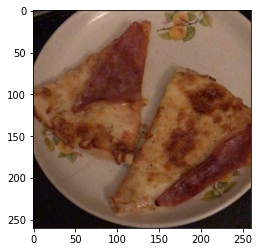

In [22]:
dataset = MyDataset('train_images/', 'train.csv', True)
print(len(dataset))
image1, label1 = dataset[1]
print(image1.shape)
show_image(image1.permute(1, 2, 0).numpy())

## 2. Data Split

In [23]:
dataset_len = len(dataset)
batch_size = 10
split_ratio = 0.20

In [24]:
indexes = np.arange(0, dataset_len)
np.random.shuffle(indexes)

In [25]:
pivot = int(np.floor(split_ratio*dataset_len))
split = indexes[pivot:], indexes[:pivot]

In [26]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(split[0]))
validation_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(split[1]))
train_size = len(split[0])
validation_size = len(split[1])
print(train_size)
print(validation_size)

7459
1864


In [27]:
i, l = iter(train_dataloader).next()
print(l)

tensor([ 3, 44, 56, 37, 31, 19,  1, 29, 27, 49])


## 3. Base Model

In [28]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d, Dropout, BatchNorm1d
from torch.nn import LeakyReLU, ReLU, Softmax, Sigmoid, Tanh
from torch.optim import Adam, SGD

In [29]:
# (10, 3, 260, 260)
# (n-f+2*p)/s + 1
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1), 
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            Linear(32*63*63 , 256),
            Linear(256 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

## 4. Train

In [40]:
def train(model, epochs, criterion, optimizer):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    validation_loss = []
    # print("Trainin Model : ")
    for epoch in tqdm(range(epochs)):
        print('Epoch: ', epoch+1)
        
        for phase in ['train', 'val']:
            dataloader = None
            datasize = None
            if phase == 'train':
                model.train() 
                dataloader = train_dataloader
                datasize = train_size
            else:
                model.eval()
                dataloader = validation_dataloader
                datasize = validation_size

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasize
            epoch_acc = running_corrects.double() / datasize
            if (phase == 'train'):
              train_loss.append(epoch_loss)
            else:
              validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)  
    print("Done")
    return model, train_loss, validation_loss

### 5. Predict 

In [41]:
def predict(model):
  correct = 0
  total = 0
  res = []
  with torch.no_grad():  
    for images, labels in validation_dataloader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      res.extend(list(predicted))
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy: ', 100*correct/total)
  return res

## 6. Evaluating Model

In [42]:
model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5

In [43]:
start = time.time()
model, train_loss, validation_loss = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.7857 Acc: 0.1014


 20%|██        | 1/5 [01:07<04:29, 67.32s/it]

val Loss: 3.7520 Acc: 0.1212

Epoch:  2
train Loss: 3.6472 Acc: 0.1339


 40%|████      | 2/5 [02:14<03:21, 67.24s/it]

val Loss: 3.6144 Acc: 0.1406

Epoch:  3
train Loss: 3.5090 Acc: 0.1611


 60%|██████    | 3/5 [03:20<02:13, 66.77s/it]

val Loss: 3.5491 Acc: 0.1636

Epoch:  4
train Loss: 3.3997 Acc: 0.1799


 80%|████████  | 4/5 [04:27<01:06, 66.70s/it]

val Loss: 3.4588 Acc: 0.1572

Epoch:  5
train Loss: 3.2985 Acc: 0.1944


100%|██████████| 5/5 [05:33<00:00, 66.74s/it]

val Loss: 3.3952 Acc: 0.1722

Best val Acc: 0.172210
Done
333.7210853099823


In [45]:
preds = predict(model)

Accuracy:  17.221030042918454


In [48]:
validation_loss

[3.7520076225755554,
 3.6144176176689213,
 3.5491175262713126,
 3.4587978365083623,
 3.3951676787224963]

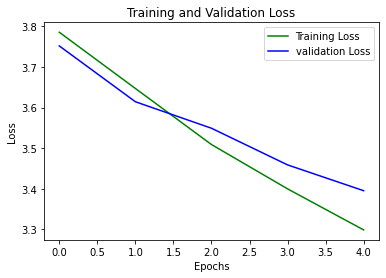

In [49]:
plt.plot(range(epochs), train_loss, 'g', label='Training Loss')
plt.plot(range(epochs), validation_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1. With Batch Norm

In [50]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            ReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            Linear(32*63*63 , 256),
            BatchNorm1d(256),
            Linear(256 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss, validation_loss = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.4190 Acc: 0.2016


 20%|██        | 1/5 [01:10<04:40, 70.05s/it]

val Loss: 3.1473 Acc: 0.2328

Epoch:  2
train Loss: 2.4846 Acc: 0.4017


 40%|████      | 2/5 [02:18<03:26, 68.83s/it]

val Loss: 3.9114 Acc: 0.1518

Epoch:  3
train Loss: 1.2953 Acc: 0.7738


 60%|██████    | 3/5 [03:26<02:17, 68.66s/it]

val Loss: 3.6458 Acc: 0.1974

Epoch:  4
train Loss: 0.5527 Acc: 0.9410


 80%|████████  | 4/5 [04:34<01:08, 68.54s/it]

val Loss: 3.5032 Acc: 0.2023

Epoch:  5
train Loss: 0.2625 Acc: 0.9843


100%|██████████| 5/5 [05:42<00:00, 68.50s/it]

val Loss: 3.4918 Acc: 0.2082

Best val Acc: 0.232833
Done
Time in seconds :  342.54032254219055


Accuracy:  23.283261802575108


In [ ]:
plt.plot(range(epochs), train_loss, 'g', label='Training Loss')
plt.plot(range(epochs), validation_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Adding new layers

#### Added **one convolution 2D layer, one max pool and one fully connected layer.** 

In [51]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            ReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss, validation_loss = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.4885 Acc: 0.1972


 20%|██        | 1/5 [01:08<04:34, 68.66s/it]

val Loss: 3.3485 Acc: 0.2023

Epoch:  2
train Loss: 2.9729 Acc: 0.2897


 40%|████      | 2/5 [02:17<03:26, 68.83s/it]

val Loss: 3.1477 Acc: 0.2366

Epoch:  3
train Loss: 2.5337 Acc: 0.4027


 60%|██████    | 3/5 [03:26<02:17, 68.96s/it]

val Loss: 3.1687 Acc: 0.2328

Epoch:  4
train Loss: 2.0091 Acc: 0.5639


 80%|████████  | 4/5 [04:35<01:08, 68.90s/it]

val Loss: 3.0950 Acc: 0.2597

Epoch:  5
train Loss: 1.4224 Acc: 0.7510


100%|██████████| 5/5 [05:44<00:00, 68.80s/it]

val Loss: 3.2413 Acc: 0.2296

Best val Acc: 0.259657
Done
Time in seconds :  344.0175051689148


Accuracy:  25.965665236051503


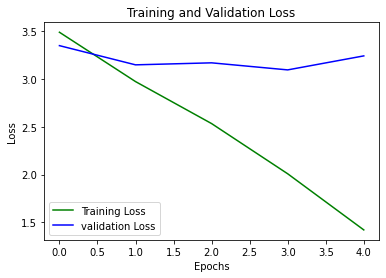

In [52]:
plt.plot(range(epochs), train_loss, 'g', label='Training Loss')
plt.plot(range(epochs), validation_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. With Dropout

1. Drop out = 0.2 (means drops 20% weight connections) 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.6113 Acc: 0.1716


 20%|██        | 1/5 [01:08<04:34, 68.66s/it]

val Loss: 3.5969 Acc: 0.1513

Epoch:  2
train Loss: 3.2307 Acc: 0.2364


 40%|████      | 2/5 [02:17<03:26, 68.68s/it]

val Loss: 3.5466 Acc: 0.1615

Epoch:  3
train Loss: 3.0103 Acc: 0.2705


 60%|██████    | 3/5 [03:26<02:17, 68.72s/it]

val Loss: 3.5382 Acc: 0.1674

Epoch:  4
train Loss: 2.8358 Acc: 0.3097


 80%|████████  | 4/5 [04:34<01:08, 68.56s/it]

val Loss: 3.3634 Acc: 0.1980

Epoch:  5
train Loss: 2.6395 Acc: 0.3475


100%|██████████| 5/5 [05:44<00:00, 68.85s/it]

val Loss: 3.4072 Acc: 0.1878

Best val Acc: 0.197961
Done
Time in seconds :  344.29113841056824


Accuracy:  19.796137339055793


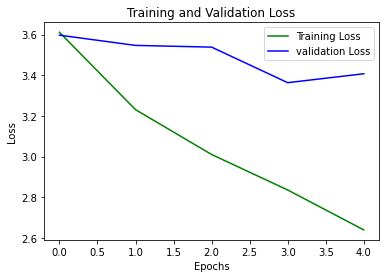

In [53]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            ReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.2),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss, validation_loss = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

plt.plot(range(epochs), train_loss, 'g', label='Training Loss')
plt.plot(range(epochs), validation_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2.Drop out = 0.3 (means drops 20% weight connections) 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.6593 Acc: 0.1654


 20%|██        | 1/5 [01:10<04:41, 70.39s/it]

val Loss: 3.6585 Acc: 0.1470

Epoch:  2
train Loss: 3.3203 Acc: 0.2203


 40%|████      | 2/5 [02:20<03:30, 70.09s/it]

val Loss: 3.6408 Acc: 0.1491

Epoch:  3
train Loss: 3.1722 Acc: 0.2435


 60%|██████    | 3/5 [03:29<02:19, 69.70s/it]

val Loss: 3.7049 Acc: 0.1454

Epoch:  4
train Loss: 3.0361 Acc: 0.2659


 80%|████████  | 4/5 [04:39<01:09, 69.64s/it]

val Loss: 3.9870 Acc: 0.1427

Epoch:  5
train Loss: 2.8803 Acc: 0.2959


100%|██████████| 5/5 [05:48<00:00, 69.79s/it]

val Loss: 3.8677 Acc: 0.1497

Best val Acc: 0.149678
Done
Time in seconds :  348.9439175128937


Accuracy:  14.967811158798284


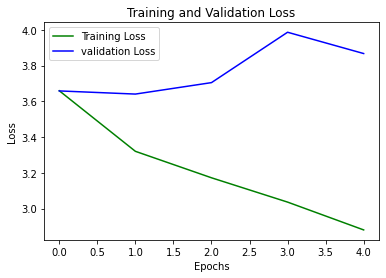

In [54]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            ReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.3),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.3),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.3),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.3),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss, validation_loss = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

plt.plot(range(epochs), train_loss, 'g', label='Training Loss')
plt.plot(range(epochs), validation_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4. Different activation functions at the end

#### Here, I have used **softmax** activation function for classification since we are doing multi-class classification, hence softmax is a good choice for this.

### 1. Using Relu function

In [57]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            ReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            Softmax()
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.2),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss4, validation_loss4 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.5983 Acc: 0.1763


 20%|██        | 1/5 [01:10<04:42, 70.68s/it]

val Loss: 3.5179 Acc: 0.1647

Epoch:  2
train Loss: 3.2524 Acc: 0.2327


 40%|████      | 2/5 [02:21<03:32, 70.74s/it]

val Loss: 3.4936 Acc: 0.1642

Epoch:  3
train Loss: 3.0583 Acc: 0.2665


 60%|██████    | 3/5 [03:31<02:21, 70.60s/it]

val Loss: 3.3874 Acc: 0.1792

Epoch:  4
train Loss: 2.8569 Acc: 0.3080


 80%|████████  | 4/5 [04:41<01:10, 70.34s/it]

val Loss: 3.3635 Acc: 0.1872

Epoch:  5
train Loss: 2.6600 Acc: 0.3452


100%|██████████| 5/5 [05:51<00:00, 70.37s/it]

val Loss: 3.3672 Acc: 0.1888

Best val Acc: 0.188841
Done
Time in seconds :  351.83541345596313


Accuracy:  18.88412017167382


### 2. Using Sigmoid function

In [58]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            Sigmoid(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            Sigmoid(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            Sigmoid(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.2),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss5, validation_loss5 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.9280 Acc: 0.0918


 20%|██        | 1/5 [01:09<04:39, 69.90s/it]

val Loss: 3.7692 Acc: 0.1282

Epoch:  2
train Loss: 3.6158 Acc: 0.1676


 40%|████      | 2/5 [02:19<03:29, 69.88s/it]

val Loss: 3.5933 Acc: 0.1744

Epoch:  3
train Loss: 3.4747 Acc: 0.1906


 60%|██████    | 3/5 [03:29<02:19, 69.91s/it]

val Loss: 3.6702 Acc: 0.1470

Epoch:  4
train Loss: 3.3861 Acc: 0.2008


 80%|████████  | 4/5 [04:39<01:10, 70.01s/it]

val Loss: 3.8642 Acc: 0.1288

Epoch:  5
train Loss: 3.3336 Acc: 0.2055


100%|██████████| 5/5 [05:49<00:00, 69.91s/it]

val Loss: 4.0998 Acc: 0.0944

Best val Acc: 0.174356
Done
Time in seconds :  349.58998823165894


Accuracy:  17.435622317596568


### 3. Using Leaky Relu

In [59]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.2),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss6, validation_loss6 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.6341 Acc: 0.1719


 20%|██        | 1/5 [01:09<04:38, 69.56s/it]

val Loss: 3.6051 Acc: 0.1513

Epoch:  2
train Loss: 3.2454 Acc: 0.2374


 40%|████      | 2/5 [02:19<03:29, 69.92s/it]

val Loss: 3.4549 Acc: 0.1668

Epoch:  3
train Loss: 3.0242 Acc: 0.2730


 60%|██████    | 3/5 [03:29<02:19, 69.68s/it]

val Loss: 3.4170 Acc: 0.1754

Epoch:  4
train Loss: 2.8286 Acc: 0.3073


 80%|████████  | 4/5 [04:38<01:09, 69.58s/it]

val Loss: 3.7068 Acc: 0.1572

Epoch:  5
train Loss: 2.6037 Acc: 0.3555


100%|██████████| 5/5 [05:47<00:00, 69.56s/it]

val Loss: 3.4485 Acc: 0.1760

Best val Acc: 0.175966
Done
Time in seconds :  347.8081443309784


Accuracy:  17.59656652360515


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

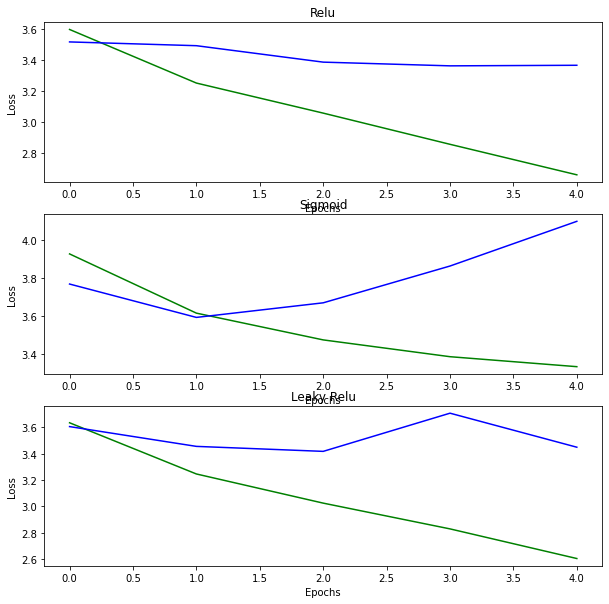

In [68]:
fig, axs = plt.subplots(3)
fig.set_size_inches(10,10)
axs[0].plot(range(epochs), train_loss4, 'g', label='Training Loss')
axs[0].plot(range(epochs), validation_loss4, 'b', label='validation Loss')
axs[0].set_title('Relu')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(range(epochs), train_loss5, 'g', label='Training Loss')
axs[1].plot(range(epochs), validation_loss5, 'b', label='validation Loss')
axs[1].set_title('Sigmoid')
axs[1].set(xlabel='Epochs', ylabel='Loss')


axs[2].plot(range(epochs), train_loss6, 'g', label='Training Loss')
axs[2].plot(range(epochs), validation_loss6, 'b', label='validation Loss')
axs[2].set_title('Leaky Relu')
axs[2].set(xlabel='Epochs', ylabel='Loss')

### 5. Different pooling strategies

### 1. Max Pool

In [ ]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.2),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss7, validation_loss7 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.6341 Acc: 0.1719


 20%|██        | 1/5 [01:09<04:38, 69.56s/it]

val Loss: 3.6051 Acc: 0.1513

Epoch:  2
train Loss: 3.2454 Acc: 0.2374


 40%|████      | 2/5 [02:19<03:29, 69.92s/it]

val Loss: 3.4549 Acc: 0.1668

Epoch:  3
train Loss: 3.0242 Acc: 0.2730


 60%|██████    | 3/5 [03:29<02:19, 69.68s/it]

val Loss: 3.4170 Acc: 0.1754

Epoch:  4
train Loss: 2.8286 Acc: 0.3073


 80%|████████  | 4/5 [04:38<01:09, 69.58s/it]

val Loss: 3.7068 Acc: 0.1572

Epoch:  5
train Loss: 2.6037 Acc: 0.3555


100%|██████████| 5/5 [05:47<00:00, 69.56s/it]

val Loss: 3.4485 Acc: 0.1760

Best val Acc: 0.175966
Done
Time in seconds :  347.8081443309784


Accuracy:  17.59656652360515


### 2. AvgPool2d

In [72]:
class Shubhnet(Module):   
    def __init__(self):
        super(Shubhnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(16), ## using batch norm
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
            
            Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),

            Conv2d(32, 64, kernel_size=5, stride=1, padding=1),  ## One convolution layer and max pool layer 
            BatchNorm2d(64),
            LeakyReLU(), 
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.2),
        )

        self.linear_layers = nn.Sequential(
            Linear(64*30*30 , 256),
            BatchNorm1d(256),
            Dropout(p=0.2),
            Linear(256 , 128), ## One fully connected layer
            Linear(128 , 61)
        )
        

    def forward(self, x):
        x = self.conv_layers(x)
        # print("conv layer = ", x.shape)
        x = x.view(x.size(0), -1)
        # print("linear layer = " , x.shape)
        x = self.linear_layers(x)
        return x

model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss8, validation_loss8 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.6141 Acc: 0.1735


 20%|██        | 1/5 [01:04<04:19, 64.93s/it]

val Loss: 3.6429 Acc: 0.1518

Epoch:  2
train Loss: 3.2577 Acc: 0.2361


 40%|████      | 2/5 [02:09<03:14, 64.85s/it]

val Loss: 3.4559 Acc: 0.1781

Epoch:  3
train Loss: 3.0291 Acc: 0.2716


 60%|██████    | 3/5 [03:14<02:09, 64.75s/it]

val Loss: 3.3778 Acc: 0.1915

Epoch:  4
train Loss: 2.8187 Acc: 0.3165


 80%|████████  | 4/5 [04:18<01:04, 64.70s/it]

val Loss: 3.3288 Acc: 0.1910

Epoch:  5
train Loss: 2.5972 Acc: 0.3628


100%|██████████| 5/5 [05:23<00:00, 64.78s/it]

val Loss: 3.2401 Acc: 0.2087

Best val Acc: 0.208691
Done
Time in seconds :  323.91835379600525


Accuracy:  20.869098712446352


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

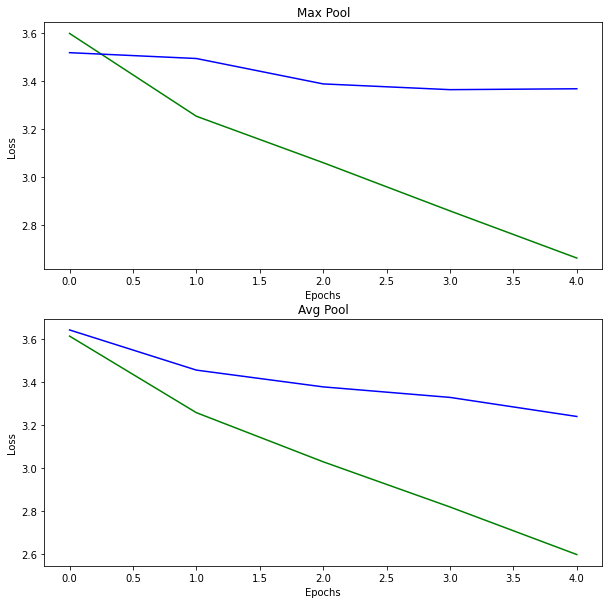

In [74]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10,10)
axs[0].plot(range(epochs), train_loss4, 'g', label='Training Loss')
axs[0].plot(range(epochs), validation_loss4, 'b', label='validation Loss')
axs[0].set_title('Max Pool')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(range(epochs), train_loss8, 'g', label='Training Loss')
axs[1].plot(range(epochs), validation_loss8, 'b', label='validation Loss')
axs[1].set_title('Avg Pool')
axs[1].set(xlabel='Epochs', ylabel='Loss')

### 6. Different optimizers

### 1. SGD

In [ ]:
model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss9, validation_loss9 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.6341 Acc: 0.1719


 20%|██        | 1/5 [01:09<04:38, 69.56s/it]

val Loss: 3.6051 Acc: 0.1513

Epoch:  2
train Loss: 3.2454 Acc: 0.2374


 40%|████      | 2/5 [02:19<03:29, 69.92s/it]

val Loss: 3.4549 Acc: 0.1668

Epoch:  3
train Loss: 3.0242 Acc: 0.2730


 60%|██████    | 3/5 [03:29<02:19, 69.68s/it]

val Loss: 3.4170 Acc: 0.1754

Epoch:  4
train Loss: 2.8286 Acc: 0.3073


 80%|████████  | 4/5 [04:38<01:09, 69.58s/it]

val Loss: 3.7068 Acc: 0.1572

Epoch:  5
train Loss: 2.6037 Acc: 0.3555


100%|██████████| 5/5 [05:47<00:00, 69.56s/it]

val Loss: 3.4485 Acc: 0.1760

Best val Acc: 0.175966
Done
Time in seconds :  347.8081443309784


Accuracy:  17.59656652360515


### 2. Adam

In [69]:
model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss10, validation_loss10 = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.5062 Acc: 0.1683


 20%|██        | 1/5 [01:07<04:31, 67.90s/it]

val Loss: 3.2862 Acc: 0.1856

Epoch:  2
train Loss: 3.1126 Acc: 0.2228


 40%|████      | 2/5 [02:17<03:25, 68.64s/it]

val Loss: 3.0485 Acc: 0.2344

Epoch:  3
train Loss: 2.9021 Acc: 0.2581


 60%|██████    | 3/5 [03:25<02:16, 68.39s/it]

val Loss: 3.0157 Acc: 0.2473

Epoch:  4
train Loss: 2.6907 Acc: 0.2928


 80%|████████  | 4/5 [04:33<01:08, 68.31s/it]

val Loss: 3.0396 Acc: 0.2382

Epoch:  5
train Loss: 2.4353 Acc: 0.3408


100%|██████████| 5/5 [05:41<00:00, 68.29s/it]

val Loss: 3.1632 Acc: 0.2361

Best val Acc: 0.247318
Done
Time in seconds :  341.4768867492676


Accuracy:  24.73175965665236


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

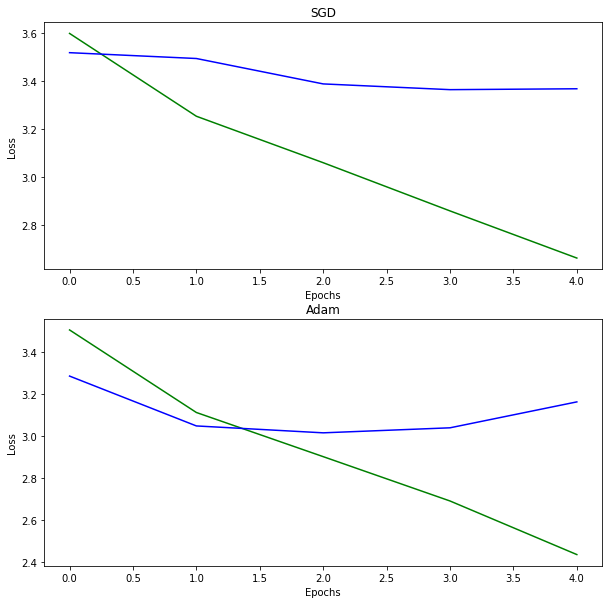

In [71]:
fig, axs = plt.subplots(2)
fig.set_size_inches(10,10)
axs[0].plot(range(epochs), train_loss9, 'g', label='Training Loss')
axs[0].plot(range(epochs), validation_loss9, 'b', label='validation Loss')
axs[0].set_title('SGD')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(range(epochs), train_loss10, 'g', label='Training Loss')
axs[1].plot(range(epochs), validation_loss10, 'b', label='validation Loss')
axs[1].set_title('Adam')
axs[1].set(xlabel='Epochs', ylabel='Loss')

### 7. Basic Augmentation like Rotation, Translation, Color Change 

In [ ]:
transform = transforms.Compose([
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.ToTensor(),
     ])

In [ ]:
def get_labels_mapping(path, attribute_name):
  metadata = pd.read_csv(path)
  labels = metadata[attribute_name].unique()
  labels_mapping = {}
  #print(len(labels))
  for i in range(len(labels)):
    labels_mapping[labels[i]] = i
  return labels_mapping

class MyDataset(Dataset):
  def __init__(self, path, csv_file, istrain=True, transform):
    self.images = []
    self.labels = []
    self.istrain = istrain
    # images_name = os.listdir(path)
    metadata = pd.read_csv(csv_file)
    
    for img in tqdm(metadata['ImageId']):
      self.images.append(path + '/' + img)
    
    # self.images = self.images[:2000]

    if(self.istrain):
      self.labels_mapping = get_labels_mapping(csv_file, 'ClassName')
      for lab in tqdm(metadata['ClassName']):
        self.labels.append(lab)
      # self.labels = self.labels[:2000]
     
  def __getitem__(self, index):
    image1 = load_image(self.images[index])
    if(self.istrain):
      label1 = self.labels[index]
      # print(label1, self.labels_mapping[label1])
      return self.transform(image1), torch.tensor(self.labels_mapping[label1])
    return transforms.ToTensor()(image1)
    
  def __len__(self):
    return len(self.images)

In [ ]:
dataset = MyDataset('train_images/', 'train.csv', True, transform)
dataset_len = len(dataset)
batch_size = 10
split_ratio = 0.20

In [ ]:
indexes = np.arange(0, dataset_len)
np.random.shuffle(indexes)
pivot = int(np.floor(split_ratio*dataset_len))
split = indexes[pivot:], indexes[:pivot]

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(split[0]))
validation_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(split[1]))
train_size = len(split[0])
validation_size = len(split[1])
print(train_size)
print(validation_size)

7459
1864


In [ ]:
model = Shubhnet().to(device)
learning_rate = 0.001
criterion = CrossEntropyLoss() #internally softmax
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
batch_size = 10
epochs = 5
start = time.time()
model, train_loss, validation_loss = train(model, epochs, criterion, optimizer)
end = time.time()
print("Time in seconds : ", end - start)
preds = predict(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
train Loss: 3.4885 Acc: 0.1972


 20%|██        | 1/5 [01:08<04:34, 68.66s/it]

val Loss: 3.3485 Acc: 0.2023

Epoch:  2
train Loss: 2.9729 Acc: 0.2897


 40%|████      | 2/5 [02:17<03:26, 68.83s/it]

val Loss: 3.1477 Acc: 0.2366

Epoch:  3
train Loss: 2.5337 Acc: 0.4027


 60%|██████    | 3/5 [03:26<02:17, 68.96s/it]

val Loss: 3.1687 Acc: 0.2328

Epoch:  4
train Loss: 2.0091 Acc: 0.5639


 80%|████████  | 4/5 [04:35<01:08, 68.90s/it]

val Loss: 3.0950 Acc: 0.2597

Epoch:  5
train Loss: 1.4224 Acc: 0.7510


100%|██████████| 5/5 [05:44<00:00, 68.80s/it]

val Loss: 3.2413 Acc: 0.2296

Best val Acc: 0.259657
Done
Time in seconds :  344.0175051689148


Accuracy:  25.965665236051503
